In [2]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [4]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

test = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=False,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


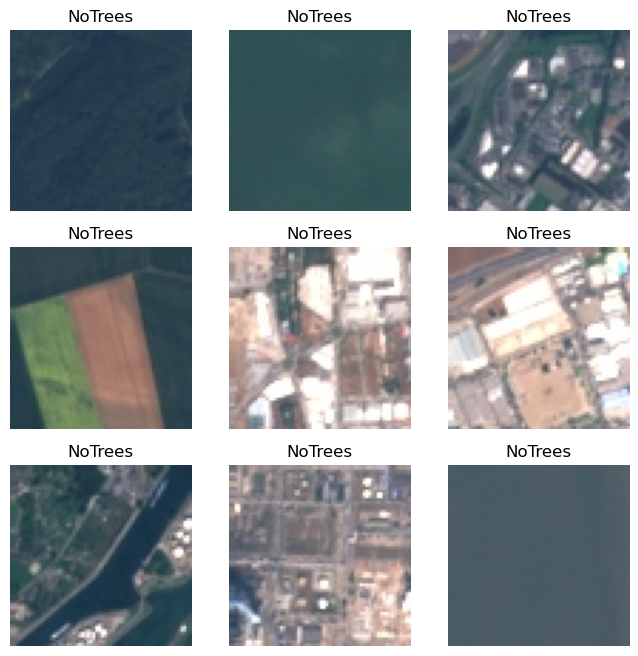

In [7]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [8]:
# build a network from scratch
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model_1 = Sequential()
model_1.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_1.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_1.add(MaxPool2D())
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid')) #1 for binary output


In [9]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0

In [11]:
from time import time

In [12]:
start = time()

history = model_1.fit(training, validation_data=test, epochs=20)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 32s 60ms/step - loss: 0.3487 - accuracy: 0.8637 - val_loss: 1.3774 - val_accuracy: 0.2778
Epoch 2/20
517/517 [==============================] - 30s 58ms/step - loss: 0.1924 - accuracy: 0.9216 - val_loss: 2.7778 - val_accuracy: 0.2865
Epoch 3/20
517/517 [==============================] - 30s 59ms/step - loss: 0.1723 - accuracy: 0.9298 - val_loss: 1.2105 - val_accuracy: 0.6239
Epoch 4/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1403 - accuracy: 0.9457 - val_loss: 0.1163 - val_accuracy: 0.9574
Epoch 5/20
517/517 [==============================] - 31s 59ms/step - loss: 0.0978 - accuracy: 0.9647 - val_loss: 0.3253 - val_accuracy: 0.8824
Epoch 6/20
517/517 [==============================] - 31s 61ms/step - loss: 0.1559 - accuracy: 0.9428 - val_loss: 0.7498 - val_accuracy: 0.6481
Epoch 7/20
517/517 [==============================] - 34s 66ms/step - loss: 0.1268 - accuracy: 0.9532 - val_loss: 0.0249 - val_accuracy:

Now that I have a proper model run, I'll make a function to plot the learning curves:

In [13]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

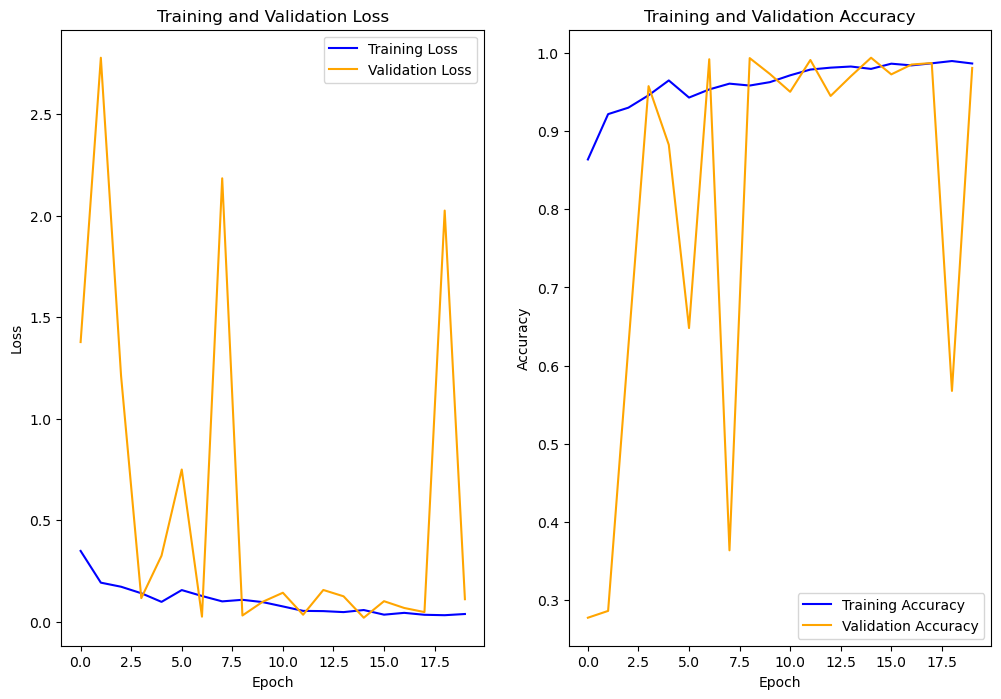

In [14]:
model_1_plots = plot_learning_curve(history)

So, it looks like improvements in the training accuracy and loss start to level off after around 10-12 epochs. The validation loss and accuracy bounce around but then appear to get worse after the 13th epoch. I will try out a slower learning rate to see if that reduces the noise in the validation learning curves and introduce early stopping:

In [15]:
#model 2
model_2 = Sequential()
model_2.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_2.add(Conv2D(16, kernel_size=3, padding='same', activation = 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, kernel_size=3, padding='same', activation= 'relu'))
model_2.add(MaxPool2D())
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [17]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)
#lr_reducer = tf.keras.callbacks.LearningRateScheduler(scheduler)

start = time()

# Fit the model
history_model_2 = model_2.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor, LearningRateReducerCb()])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
516/517 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9984
Epoch: 0. Reducing Learning Rate from 0.00023345189401879907 to 0.00023111737391445786
517/517 [==============================] - 31s 59ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0612 - val_accuracy: 0.9879
Epoch 2/20
516/517 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9981
Epoch: 1. Reducing Learning Rate from 0.00023111737391445786 to 0.00022880620963405818
517/517 [==============================] - 31s 60ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0915 - val_accuracy: 0.9831
Epoch 3/20
516/517 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994
Epoch: 2. Reducing Learning Rate from 0.00022880620963405818 to 0.00022651815379504114
517/517 [==============================] - 32s 61ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0920 - val_accuracy: 0.9840
Epoch 4/20
516/517 [============================>.] 

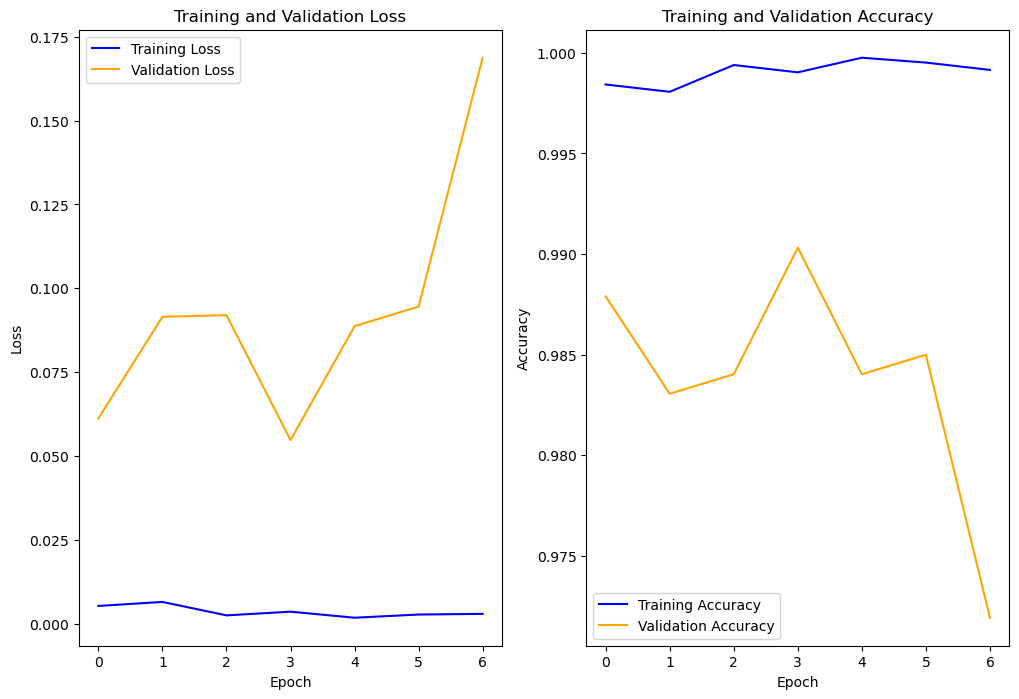

In [34]:
model_2_plots = plot_learning_curve(history_model_2)

Reducing the learning rate got rid of a lot of the jumpiness in the validation learning curves. And with the early stopping callback parameter validation accuracy hit a peak on the 4th epoch and did not improve past that mark after three more epochs and so training stopped.

In [35]:
#model 3
model_3 = Sequential()
model_3.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_3.add(Conv2D(24, kernel_size=3, padding='same', activation = 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Conv2D(48, kernel_size=3, padding='same', activation= 'relu'))
model_3.add(MaxPool2D())
model_3.add(BatchNormalization())
model_3.add(Flatten())
model_3.add(Dense(96, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 24)        672       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 24)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 24)       96        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 48)        10416     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 48)      

In [30]:
start = time()

# Fit the model
history_model_3 = model_3.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor, LearningRateReducerCb()])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 40s 78ms/step - loss: 0.1221 - accuracy: 0.9528 - val_loss: 0.2176 - val_accuracy: 0.8863
Epoch 2/20
517/517 [==============================] - 42s 81ms/step - loss: 0.0897 - accuracy: 0.9653 - val_loss: 0.5358 - val_accuracy: 0.8732
Epoch 3/20
517/517 [==============================] - 42s 80ms/step - loss: 0.1046 - accuracy: 0.9602 - val_loss: 0.1092 - val_accuracy: 0.9652
Epoch 4/20
517/517 [==============================] - 42s 82ms/step - loss: 0.0818 - accuracy: 0.9690 - val_loss: 0.2437 - val_accuracy: 0.9303
Epoch 5/20
517/517 [==============================] - 42s 82ms/step - loss: 0.0899 - accuracy: 0.9646 - val_loss: 1.2265 - val_accuracy: 0.6873
Epoch 6/20
517/517 [==============================] - 41s 80ms/step - loss: 0.0613 - accuracy: 0.9780 - val_loss: 0.1614 - val_accuracy: 0.9564
Elapsed Time = 249.9516351222992 seconds


So with this model, validation accuracy hit a peak on the 3rd epoch and did not improve past that mark after three more epochs and so training stopped.

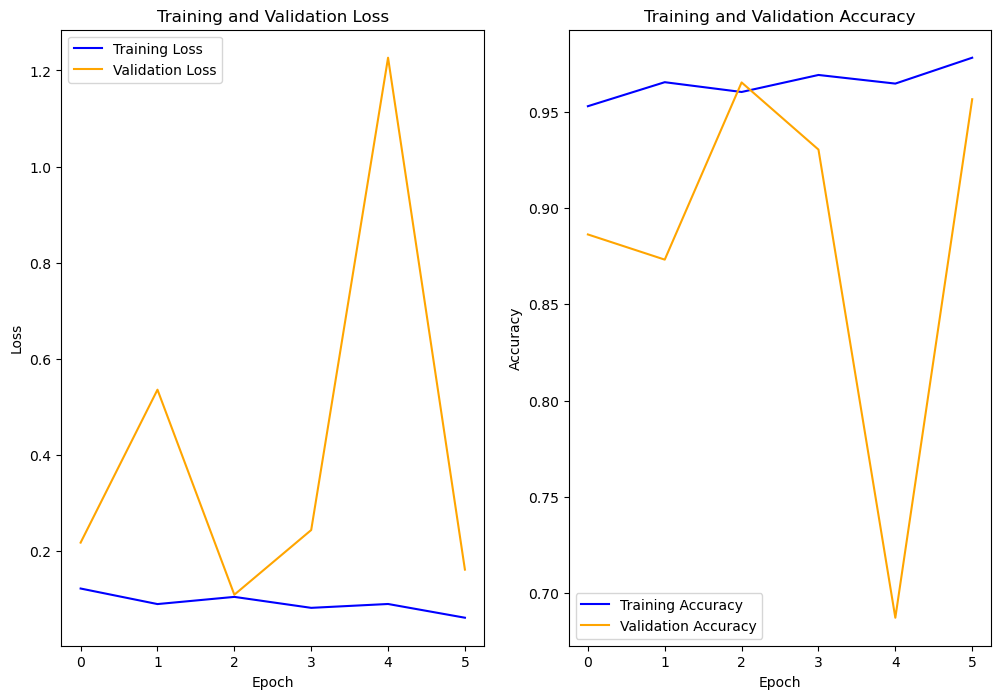

In [31]:
model_3_plots = plot_learning_curve(history_model_3)

I'll now try a model similar to the previous, but with sigmoid instead of relu activation functions for the convolutional layers:

In [32]:
#model 4
model_4 = Sequential()
model_4.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_4.add(Conv2D(24, kernel_size=3, padding='same', activation = 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Conv2D(48, kernel_size=3, padding='same', activation= 'sigmoid'))
model_4.add(MaxPool2D())
model_4.add(BatchNormalization())
model_4.add(Flatten())
model_4.add(Dense(96, activation='sigmoid'))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 24)        672       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 24)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 24)       96        
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 48)        10416     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 48)      

In [33]:
# we'll do early stopping again
start = time()

# Fit the model
history_model_4 = model_4.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 44s 84ms/step - loss: 0.4670 - accuracy: 0.7861 - val_loss: 0.5981 - val_accuracy: 0.8054
Epoch 2/20
517/517 [==============================] - 45s 86ms/step - loss: 0.3394 - accuracy: 0.8491 - val_loss: 0.4648 - val_accuracy: 0.8030
Epoch 3/20
517/517 [==============================] - 45s 86ms/step - loss: 0.2752 - accuracy: 0.8880 - val_loss: 0.2789 - val_accuracy: 0.8761
Epoch 4/20
517/517 [==============================] - 46s 88ms/step - loss: 0.2413 - accuracy: 0.9041 - val_loss: 0.7606 - val_accuracy: 0.5934
Epoch 5/20
517/517 [==============================] - 46s 89ms/step - loss: 0.2134 - accuracy: 0.9185 - val_loss: 0.3047 - val_accuracy: 0.8538
Epoch 6/20
517/517 [==============================] - 45s 86ms/step - loss: 0.1957 - accuracy: 0.9260 - val_loss: 0.1671 - val_accuracy: 0.9337
Epoch 7/20
517/517 [==============================] - 45s 87ms/step - loss: 0.1548 - accuracy: 0.9441 - val_loss: 0.2264 - val_accuracy:

With sigmoid activation functions in the convolutional layers, the network hits peak validation accuracy after the 9th epoch and stops early after the 12th when validation accuracy does not improve further.

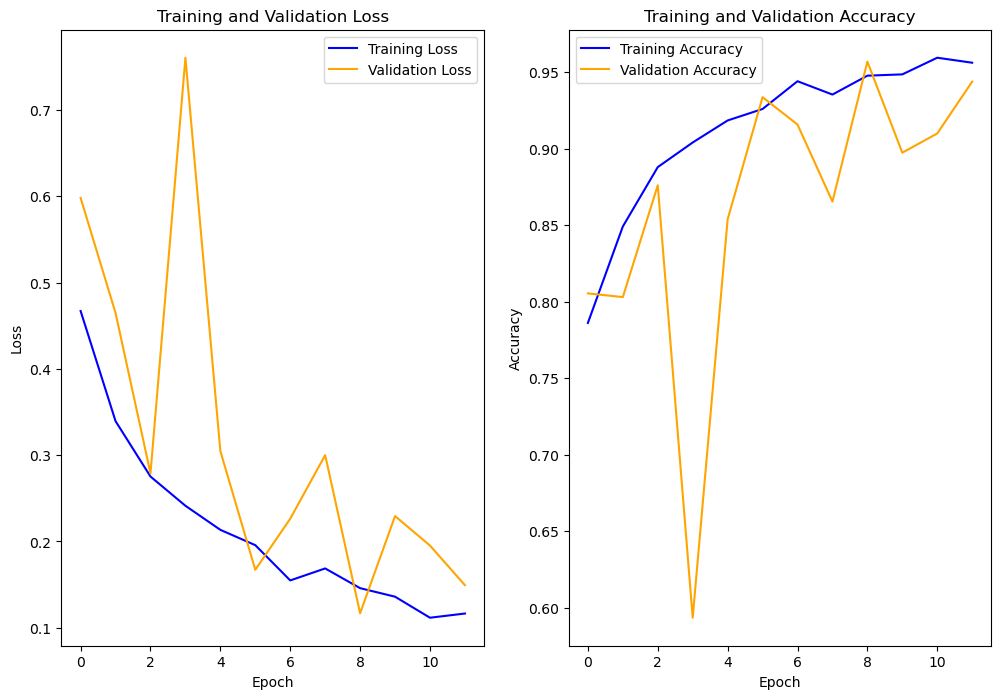

In [34]:
model_4_plots = plot_learning_curve(history_model_4)

In [36]:
max(history_model_4.history['val_accuracy'])

0.9569215774536133

In [37]:
max(history_model_3.history['val_accuracy'])

0.9651500582695007

So the network with two convolutional layers and one dense layer all using the relu activation function performed slightly better than the one with sigmoid activation functions. Next I will try an additional convolutional layer, using relu activation again.

In [38]:
#model 5
model_5 = Sequential()
model_5.add(Rescaling((1./255), input_shape=(img_h, img_w, 3)))
model_5.add(Conv2D(24, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(48, kernel_size=3, padding='same', activation= 'relu'))
model_5.add(MaxPool2D())
model_5.add(BatchNormalization())
model_5.add(Conv2D(96, kernel_size=3, padding='same', activation = 'relu'))
model_5.add(Flatten())
model_5.add(Dense(96, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 24)        672       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 32, 32, 24)       0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 24)       96        
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 48)        10416     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 48)      

In [39]:
# we'll do early stopping again
start = time()

# Fit the model
history_model_5 = model_5.fit(training, validation_data=test, epochs=20, callbacks=[early_stopping_monitor])

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/20
517/517 [==============================] - 58s 111ms/step - loss: 0.3853 - accuracy: 0.8591 - val_loss: 0.3097 - val_accuracy: 0.9027
Epoch 2/20
517/517 [==============================] - 57s 111ms/step - loss: 0.2330 - accuracy: 0.9061 - val_loss: 1.8636 - val_accuracy: 0.4927
Epoch 3/20
517/517 [==============================] - 57s 111ms/step - loss: 0.2066 - accuracy: 0.9177 - val_loss: 0.3127 - val_accuracy: 0.8761
Epoch 4/20
517/517 [==============================] - 58s 112ms/step - loss: 0.1820 - accuracy: 0.9261 - val_loss: 0.5343 - val_accuracy: 0.7420
Elapsed Time = 231.16218447685242 seconds
